In [1]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [99]:
data_dir = '/content/drive/My Drive/data/predictBookprices'

In [100]:
df = pd.read_csv(data_dir + '/Data_Train.csv', encoding='cp1252')

In [101]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [102]:
df.shape

(6237, 9)

In [103]:
df.isna().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
Price           0
dtype: int64

In [104]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [105]:
df = prepare_data(df)
# df.to_csv("Data/new_data.csv", index=None)
# data = pd.read_csv("Data/new_data.csv")
df.head()


,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


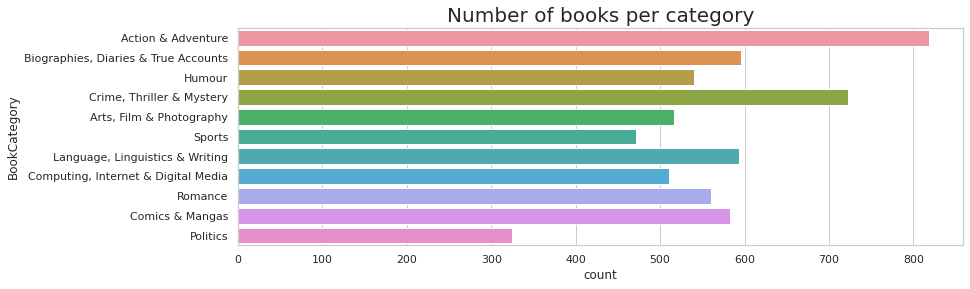

In [106]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=df).set_title("Number of books per category",fontsize=20)
plt.show()

In [107]:
data = df

Text(0.5, 1.0, 'Price of Books vs reviews')

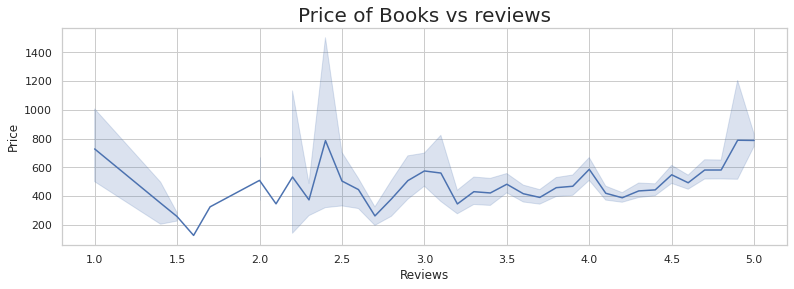

In [108]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

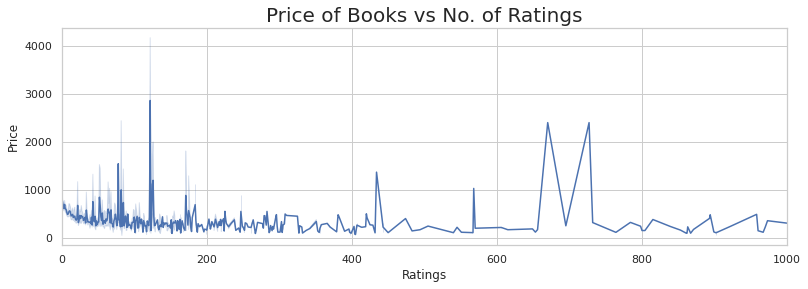

In [109]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

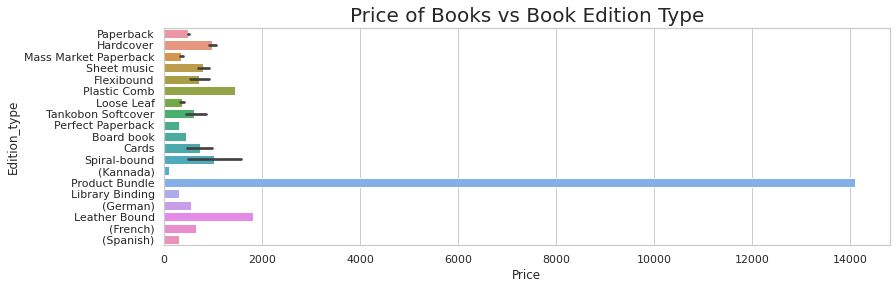

In [110]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

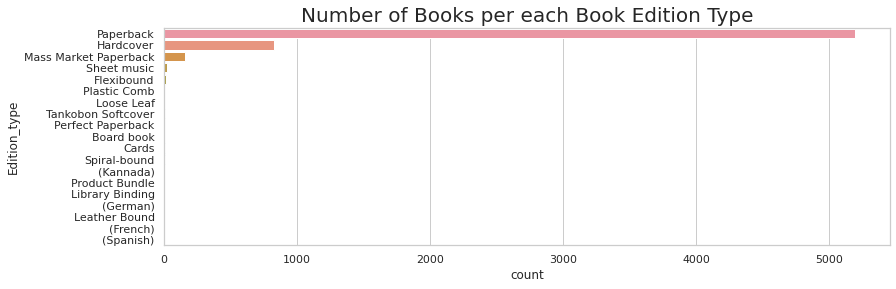

In [111]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

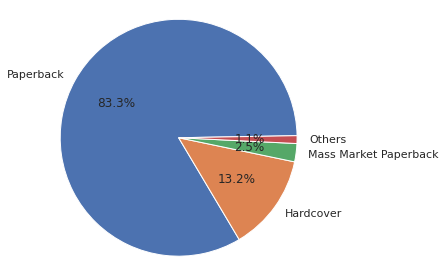

In [112]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [113]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"

In [114]:
data['Edition_type'].value_counts()

Paperback                5193
Hardcover                 823
Mass Market Paperback     155
Other_editions             66
Name: Edition_type, dtype: int64

In [115]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"

In [116]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"

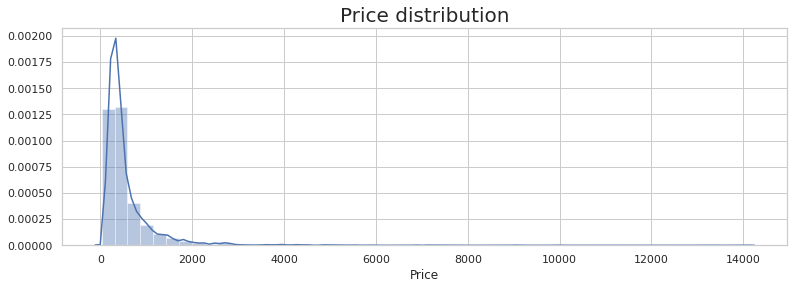

In [117]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

In [118]:
import re
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # text = text.split()

    return text

In [119]:
import string
data['Synopsis'] = data['Synopsis'].apply(text_to_word_list)
data["num_words_synops"] = data["Synopsis"].apply(lambda x: len(str(x).split()))
## Number of characters in the Synopsis ##
data["num_chars_synops"] = data["Synopsis"].apply(lambda x: len(str(x)))

## Number of punctuations in the Synopsis ##
data["num_punct_synops"] = data['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
data["num_words_title"] = data["Title"].apply(lambda x: len(str(x).split()))
data["mean_word_len"] = data["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [120]:
data['Title'] = data['Title'].apply(text_to_word_list)

Text(0.5, 1.0, 'Cheaper Books : Top words in titles')

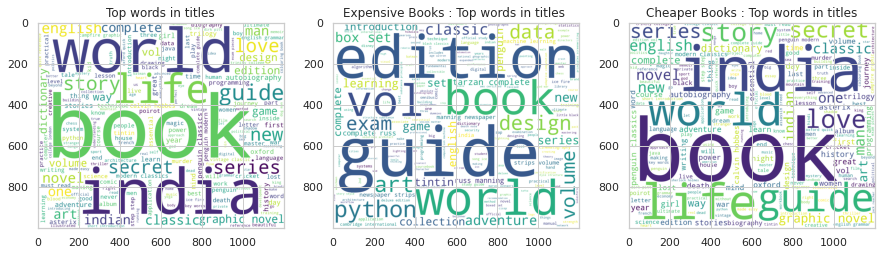

In [121]:
from wordcloud import WordCloud, STOPWORDS
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 15)
text = ' '.join(data['Title'].values)
wordcloud1 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
data2 = data[data['Price'] >= 1500]
text = ' '.join(data2['Title'].values)
wordcloud2 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
# plt.imshow(wordcloud)
data2 = data[data['Price'] < 1500]
text = ' '.join(data2['Title'].values)
wordcloud3 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax[0].imshow(wordcloud1)
ax[1].imshow(wordcloud2)
ax[2].imshow(wordcloud3)
ax[0].set_title("Top words in titles")
ax[1].set_title("Expensive Books : Top words in titles ")
ax[2].set_title("Cheaper Books : Top words in titles")


In [122]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
data['Title_clean'] = data['Title'].str.split().apply(lambda x: " ".join([item for item in x if item not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
data[data['Price'] > 1500].Title_clean.str.split(expand=True).stack().value_counts()[:20]

:           183
-            86
guide        36
edition      27
complete     24
set          23
1            22
world        17
volume       17
learning     17
python       14
2            14
art          13
design       13
data         12
classics     11
box          11
4            11
vol          11
exam         10
dtype: int64

In [124]:
data[data['Price'] < 1500].Title_clean.str.split(expand=True).stack().value_counts()[:20]

:           2661
-            744
book         392
1            262
guide        200
english      179
india        177
classics     177
edition      174
series       168
2            168
world        161
life         142
story        136
vol          135
3            133
novel        124
one          124
man          118
penguin      117
dtype: int64

In [47]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-07-23 17:19:33--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.117
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  13.7MB/s    in 2m 18s  

2020-07-23 17:21:51 (11.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [48]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [139]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    # tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens

def get_mean_vector(word2vec_model, words):
    list_vec = []
    extra_vocab = {}
    for word in words:
        if word in word2vec_model.vocab:
            list_vec.append(word2vec_model[word])
        else:
            if word not in extra_vocab.keys():
                extra_vocab[word] = np.random.normal(0, 1, 300)
            list_vec.append(extra_vocab[word])
    if len(list_vec) == 0:
        list_vec.append(np.random.normal(0, 1, 300))
    list_vec = np.array(list_vec)
    return np.mean(list_vec, axis=0)

def get_word_vectors(df, word2vec):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(word2vec, i) for i in sentences_train])
    headers = ["TitileV"+ str(i) for i in range(300)]
    sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train


# model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
sentences = get_word_vectors(data['Title'], word2vec)
# headers = ["TitleV"+ str(i) for i in range(300)]
# sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
# data = pd.concat([data, sentences], axis=1)

In [140]:
sentences.shape, data.shape, sentences.columns

((6237, 300),
 (6237, 16),
 Index(['TitileV0', 'TitileV1', 'TitileV2', 'TitileV3', 'TitileV4', 'TitileV5',
        'TitileV6', 'TitileV7', 'TitileV8', 'TitileV9',
        ...
        'TitileV290', 'TitileV291', 'TitileV292', 'TitileV293', 'TitileV294',
        'TitileV295', 'TitileV296', 'TitileV297', 'TitileV298', 'TitileV299'],
       dtype='object', length=300))

In [142]:
data = pd.concat([data, sentences], axis=1)

In [143]:
data.shape

(6237, 316)

In [144]:
le = LabelEncoder()
le.fit(data['BookCategory'])
data['BookCategory'] = le.transform(data['BookCategory'])

In [145]:
leET = LabelEncoder()
leET.fit(data['Edition_type'])
data['Edition_type'] = leET.transform(data['Edition_type'])

In [146]:
leET = LabelEncoder()
leET.fit(data['Author'])
data['Author'] = leET.transform(data['Author'])

In [147]:
leET = LabelEncoder()
leET.fit(data['Genre'])
data['Genre'] = leET.transform(data['Genre'])

In [148]:
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year,num_words_synops,num_chars_synops,num_punct_synops,num_words_title,mean_word_len,Title_clean,TitileV0,TitileV1,TitileV2,TitileV3,TitileV4,TitileV5,TitileV6,TitileV7,TitileV8,TitileV9,TitileV10,TitileV11,TitileV12,TitileV13,TitileV14,TitileV15,TitileV16,TitileV17,TitileV18,TitileV19,TitileV20,TitileV21,TitileV22,TitileV23,...,TitileV260,TitileV261,TitileV262,TitileV263,TitileV264,TitileV265,TitileV266,TitileV267,TitileV268,TitileV269,TitileV270,TitileV271,TitileV272,TitileV273,TitileV274,TitileV275,TitileV276,TitileV277,TitileV278,TitileV279,TitileV280,TitileV281,TitileV282,TitileV283,TitileV284,TitileV285,TitileV286,TitileV287,TitileV288,TitileV289,TitileV290,TitileV291,TitileV292,TitileV293,TitileV294,TitileV295,TitileV296,TitileV297,TitileV298,TitileV299
0,the prisoner gold the hunters 3,52,4.0,8,the hunters return in their third brilliant no...,0,0,220.00,3,2016,133,767,1,6,4.766917,prisoner gold hunters 3,0.037659,-0.000275,-0.049347,0.116150,0.052856,-0.068573,-0.015137,-0.082947,0.078125,0.212158,0.080322,-0.132141,0.097076,0.018005,-0.052246,0.018921,0.011047,0.152618,-0.080353,-0.158226,-0.034119,-0.016235,-0.015503,0.010765,...,-0.051849,-0.121613,0.046066,-0.092587,0.102539,0.041473,-0.118652,-0.030544,-0.082031,0.113358,0.137695,0.185272,0.020996,-0.052246,0.133270,-0.035767,-0.087112,-0.115982,-0.009033,0.147095,-0.027466,0.049377,0.095306,0.057556,-0.023560,-0.007690,-0.144348,0.032898,0.086029,0.068481,-0.037407,-0.122665,-0.171021,-0.096313,0.060944,-0.004349,-0.027222,-0.067741,0.138672,0.104004
1,guru dutt : a tragedy in three acts,248,3.9,14,a layered portrait of a troubled genius for wh...,21,2,202.93,3,2012,198,1133,5,7,4.722222,guru dutt : tragedy three acts,0.123438,0.046130,0.082361,0.054077,0.010156,0.009363,0.013574,-0.171777,0.041064,-0.001758,0.039722,-0.076978,-0.015039,0.068408,-0.059717,0.167236,0.034546,0.002136,-0.027795,-0.156787,0.092627,0.087476,-0.040723,-0.062341,...,0.009766,0.033740,0.054663,-0.033838,0.041699,0.165991,0.001636,0.101541,-0.064258,-0.082520,0.056152,0.023779,-0.033472,0.103442,0.017285,0.065300,-0.077979,0.102783,-0.066284,0.004388,-0.037549,-0.083203,0.008984,0.030573,0.153271,-0.071846,-0.092694,-0.022974,0.005347,0.136389,0.036829,-0.071692,-0.098975,-0.057690,-0.100287,-0.045020,-0.030615,-0.097173,-0.075012,0.058423
2,leviathan penguin classics,339,4.8,6,during the time men live without a common pow...,65,6,299.00,3,1982,263,1631,4,3,5.197719,leviathan penguin classics,0.144531,0.082581,-0.179362,0.276693,0.045492,-0.126953,-0.081868,0.038900,0.065735,0.049764,-0.149190,-0.079631,0.101237,-0.089518,-0.170898,0.038900,-0.103353,-0.039714,0.007487,-0.077718,0.058757,0.059184,0.122518,0.022868,...,0.045573,0.184733,-0.132487,0.026286,-0.157715,0.031576,-0.120036,0.049194,-0.041016,0.094482,-0.059082,0.143962,-0.059408,0.131510,0.042643,-0.013601,-0.035645,0.081706,-0.038574,0.056152,-0.066081,0.050456,0.015523,0.144857,0.079544,-0.045492,0.007935,0.008789,0.085938,0.180257,-0.008626,-0.104980,-0.207092,-0.070923,0.123372,-0.133464,0.087148,0.111328,-0.057454,-0.017588
3,a pocket full of rye miss marple,6,4.1,13,a handful of grain is found in the pocket of a...,32,5,180.00,3,2017,76,415,0,7,4.460526,pocket full rye miss marple,0.061127,-0.301164,-0.059562,0.010168,-0.137878,0.302239,0.310670,-0.087422,0.078714,-0.195078,-0.064698,0.238465,-0.038475,0.297046,-0.310164,0.062709,0.161207,0.252226,0.359968,0.160587,-0.188721,-0.088891,-0.053828,0.231905,...,-0.167058,0.087232,-0.381975,0.172582,-0.312192,-0.069452,0.244396,-0.189010,-0.087966,0.191753,0.094000,-0.081888,0.145644,0.038194,-0.007852,0.126496,0.278041,-0.018460,-0.063346,-0.123114,0.112994,-0.290460,0.108516,0.168574,-0.133190,-0.006341,0.025841,0.108310,-0.243247,0.059598,0.026552,0.082057,-0.162981,0.126150,-0.122540,0.077580,0.040454,-0.352501,-0.231660,-0.167690
4,life 70 years of extraordinary photography,248,5.0,1,for

In [149]:
data_ = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((6237, 316),
 Index(['Title', 'Author', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
        'BookCategory', 'Price', 'Edition_type', 'Edition_year',
        ...
        'TitileV290', 'TitileV291', 'TitileV292', 'TitileV293', 'TitileV294',
        'TitileV295', 'TitileV296', 'TitileV297', 'TitileV298', 'TitileV299'],
       dtype='object', length=316))

Text(0.5, 1.0, 'Log of Price Distribution (gives Normalk Distr.)')

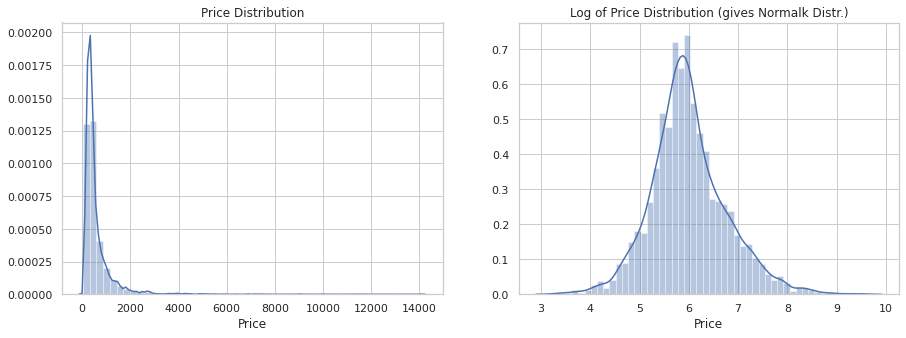

In [150]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.distplot(data['Price'], ax=ax[0])
sns.distplot(np.log1p(data['Price']), ax=ax[1])
ax[0].set_title("Price Distribution")
ax[1].set_title("Log of Price Distribution (gives Normalk Distr.)")
# ax[2].set_title("Cheaper Books : Top words in titles")

In [164]:
def normalize_data(data):
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df2 = pd.DataFrame(x_scaled)
    return df2

In [165]:
label = np.log1p(data['Price'])
final_data = data.drop(columns=['Price', 'Title', 'Synopsis', 'Edition_year', 'Title_clean'])
final_data = normalize_data(final_data)

In [166]:
final_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310
0,0.139037,0.750,0.001150,0.000000,0.0,1.0,0.059633,0.059264,0.007576,0.161290,0.573896,0.573684,0.568953,0.478303,0.575500,0.420284,0.576718,0.521072,0.363986,0.598152,0.502863,0.583331,0.406418,0.457556,0.461395,0.543058,0.493125,0.609972,0.403280,0.467782,0.542411,0.423623,0.525215,0.435531,0.508442,0.460178,0.485338,0.388045,0.633897,0.502853,...,0.535232,0.547101,0.473078,0.517309,0.579960,0.536432,0.410867,0.553681,0.524498,0.520556,0.566379,0.627626,0.515050,0.545280,0.531957,0.411304,0.495600,0.498862,0.425834,0.549658,0.530031,0.526172,0.413679,0.567887,0.397485,0.520616,0.349550,0.583635,0.543088,0.516706,0.544361,0.506450,0.459337,0.444507,0.529131,0.533745,0.502430,0.579916,0.512156,0.531382
1,0.663102,0.725,0.002135,0.196262,0.2,1.0,0.089450,0.087804,0.037879,0.193548,0.567087,0.590622,0.578079,0.509126,0.562643,0.411468,0.590973,0.526354,0.346328,0.589026,0.450093,0.574572,0.416534,0.436990,0.471214,0.541380,0.523685,0.613994,0.372816,0.478409,0.542679,0.451892,0.547151,0.429844,0.492904,0.481017,0.510205,0.435947,0.627335,0.477846,...,0.548866,0.587408,0.474558,0.529022,0.567951,0.560806,0.434123,0.574763,0.529115,0.479183,0.551962,0.605442,0.502917,0.573924,0.508784,0.430277,0.497511,0.541738,0.412881,0.519491,0.528117,0.496706,0.395337,0.561980,0.434817,0.504512,0.358367,0.571065,0.523314,0.529438,0.563144,0.516311,0.473237,0.452668,0.497766,0.526002,0.501756,0.574630,0.467207,0.521903
2,0.906417,0.950,0.000821,0.607477,0.6,1.0,0.119266,0.126638,0.030303,0.064516,0.639530,0.594787,0.585248,0.447877,0.608754,0.418764,0.566040,0.508795,0.388209,0.595101,0.462802,0.533818,0.416047,0.458319,0.440448,0.516405,0.497242,0.590387,0.364344,0.485543,0.557433,0.444337,0.541167,0.466655,0.511014,0.475885,0.486665,0.380662,0.647666,0.483852,...,0.556789,0.626583,0.442327,0.541010,0.528590,0.534495,0.410600,0.566408,0.535152,0.516569,0.531587,0.621951,0.497139,0.579087,0.513850,0.415465,0.506371,0.537607,0.419150,0.530434,0.522703,0.526412,0.396726,0.586997,0.419252,0.511127,0.375543,0.578211,0.543065,0.537662,0.551643,0.509871,0.452377,0.449872,0.541276,0.509163,0.525120,0.612074,0.470901,0.506095
3,0.016043,0.775,0.001971,0.299065,0.5,1.0,0.033486,0.031815,0.000000,0.193548,0.527217,0.578318,0.509778,0.475913,0.553548,0.380903,0.644541,0.581011,0.363097,0.598297,0.402403,0.552046,0.474378,0.432691,0.515756,0.485123,0.502147,0.635678,0.423445,0.556813,0.601897,0.389141,0.509848,0.426888,0.555443,0.491954,0.492793,0.387939,0.660596,0.428004,...,0.509739,0.601286,0.399361,0.570178,0.498098,0.514719,0.481057,0.528388,0.522956,0.537114,0.558653,0.590926,0.542816,0.561919,0.503761,0.441765,0.572022,0.517976,0.413546,0.492538,0.556687,0.450642,0.416486,0.592189,0.374341,0.520955,0.378600,0.600602,0.462390,0.515040,0.560544,0.546054,0.460888,0.491517,0.493437,0.549344,0.515856,0.528778,0.434256,0.474878
4,0.663102,1.000,0.000000,0.775701,0.1,0.0,0.047248,0.049361,0.007576,0.161290,0.615156,0.573801,0.587083,0.403998,0.496422,0.365937,0.556560,0.489437,0.302490,0.568572,0.460589,0.613109,0.462474,0.470262,0.387014,0.498890,0.526576,0.668143,0.388973,0.482160,0.596841,0.479138,0.604557,0.412020,0.420651,0.460313,0.523059,0.388318,0.610562,0.474988,...,0.575483,0.519161,0.464633,0.525073,0.552326,0.580738,0.378843,0.564483,0.502785,0.593310,0.475842,0.558327,0.555048,0.540615,0.607814,0.383029,0.414987,0.435751,0.413531,0.527921,0.550123,0.559426,0.421471,0.571064,0.431640,0.468330,0.342146,0.556776,0.510953,0.485498,0.503267,0.533564,0.450281,0.445027,0.498817,0.533536,0.508373,0.606114,0.486575,0.508929


In [167]:
x_train, x_test, y_train, y_test = train_test_split(final_data, label, test_size=0.10, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5613, 311), (624, 311), (5613,), (624,))

In [ ]:
mlp_reg = MLPRegressor(verbose=True, n_iter_no_change=100)
mlp_reg.fit(x_train, y_train)
y_pred = reg_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(reg_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))

In [171]:
reg_model = DecisionTreeRegressor(max_depth=5)

reg_model.fit(x_train, y_train)

y_pred = reg_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(reg_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))
# print("Test: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train :  0.6418675309515859
test :  0.6845281195326633


In [172]:
import xgboost
# best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=4,
#                  min_child_weight=1.5,
#                  n_estimators=2000,                                                                    
#                  reg_alpha=0.85,
#                  reg_lambda=0.45,
#                  subsample=0.2,
#                  seed=42)
best_xgb_model = xgboost.XGBRegressor(max_depth= 3, learning_rate=0.07,
                                      n_estimators=1000)
best_xgb_model.fit(x_train,y_train)

y_pred = best_xgb_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(best_xgb_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))

[18:01:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train :  0.2699162629136654
test :  0.5835247685883584
